## Import packages

In [42]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

### Find biggest extremes

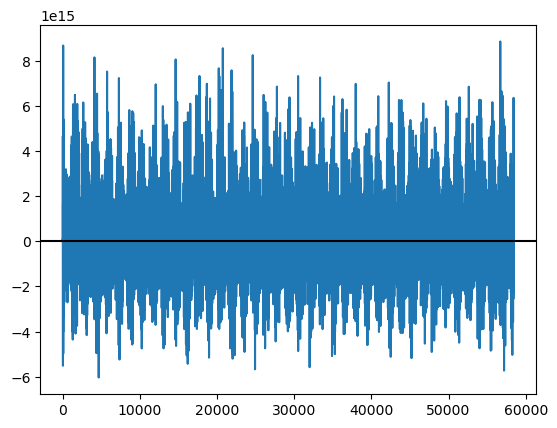

In [93]:
which_lat = 40
lat_idx = era_fncts.get_lat_idx(which_lat)
field = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat).values

height_req_max = 3 * np.std(field)
height_req_min = 3 * np.std(field)
new_ind_min = signal.find_peaks(-field, height=height_req_min,  distance=12)
new_ind_max = signal.find_peaks(field, height=height_req_max,  distance=12)

plt.plot(range(len(field)), field)

#for idx in new_ind_max[0]:
    #plt.axvline(idx, color='r')
#for idx in new_ind_min[0]:
   # plt.axvline(idx, color='g')

plt.axhline(0, color='k') 

plt.show()

### Only look at extremes during NDJF

In [94]:
ind_mins = new_ind_min[0]
for idx in new_ind_min[0]:
    times_info = era_fncts.get_times_of_idx(idx)
    which_idx = era_fncts.check_idx_months(times_info[2], times_info[3])
    ind_mins = np.delete(ind_mins, np.where(ind_mins == which_idx))

ind_maxs = new_ind_max[0]
for idx in new_ind_max[0]:
    times_info = era_fncts.get_times_of_idx(idx)
    which_idx = era_fncts.check_idx_months(times_info[2], times_info[3])
    ind_maxs = np.delete(ind_maxs, np.where(ind_maxs == which_idx))
    
print(len(ind_mins))
print(len(ind_maxs))

29
113


### Load the AHT data for those extremes and average them

In [95]:
total_aht_max = aht_ds.total_aht_no_seasons[ind_maxs,:].mean(['time'])
eddy_aht_max = aht_ds.eddy_aht_no_seasons[ind_maxs,:].mean(['time'])
mmc_aht_max = aht_ds.mmc_aht_no_seasons[ind_maxs,:].mean(['time'])

total_aht_min = aht_ds.total_aht_no_seasons[ind_mins,:].mean(['time'])
eddy_aht_min = aht_ds.eddy_aht_no_seasons[ind_mins,:].mean(['time'])
mmc_aht_min = aht_ds.mmc_aht_no_seasons[ind_mins,:].mean(['time'])


### For context make climatologies of mean AHT and AHT std. dev. for NDJF

In [65]:
monthly_aves = aht_ds.groupby('time.month').mean(['time'])
monthly_stds = aht_ds.groupby('time.month').std(['time'])

In [89]:
total_aht_ndjf = monthly_aves.total_aht[[0, 1, 10, 11],:].mean(['month'])
eddy_aht_ndjf = monthly_aves.eddy_aht[[0, 1, 10, 11],:].mean(['month'])
mmc_aht_ndjf = monthly_aves.mmc_aht[[0, 1, 10, 11],:].mean(['month'])

total_std_ndjf = monthly_stds.total_aht[[0, 1, 10, 11],:].mean(['month'])
eddy_std_ndjf = monthly_stds.eddy_aht[[0, 1, 10, 11],:].mean(['month'])
mmc_std_ndjf = monthly_stds.mmc_aht[[0, 1, 10, 11],:].mean(['month'])

### Plot these extremes for the latitude chosen

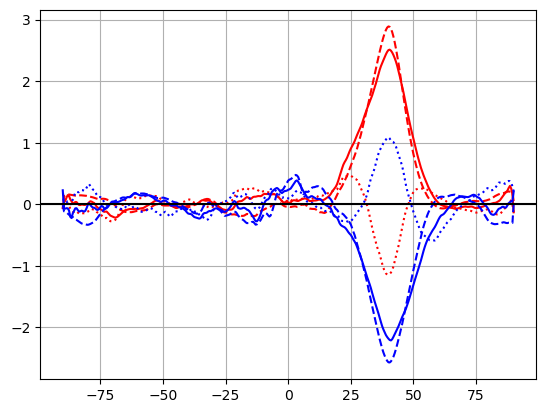

In [96]:
#In W units
#plt.plot(lats, total_aht_max, '-', color='r')
#plt.plot(lats, eddy_aht_max, '--', color='r')
#plt.plot(lats, mmc_aht_max, ':', color='r')

#plt.plot(lats, total_aht_min, '-', color='b')
#plt.plot(lats, eddy_aht_min, '--', color='b')
#plt.plot(lats, mmc_aht_min, ':', color='b')

#In standard anomaly units
plt.plot(lats, total_aht_max/total_std_ndjf, '-', color='r')
plt.plot(lats, eddy_aht_max/eddy_std_ndjf, '--', color='r')
plt.plot(lats, mmc_aht_max/mmc_std_ndjf, ':', color='r')

plt.plot(lats, total_aht_min/total_std_ndjf, '-', color='b')
plt.plot(lats, eddy_aht_min/eddy_std_ndjf, '--', color='b')
plt.plot(lats, mmc_aht_min/mmc_std_ndjf, ':', color='b')

#Climatology
#plt.plot(lats, total_aht_ndjf, '-', color='k')
#plt.plot(lats, eddy_aht_ndjf, '--', color='k')
#plt.plot(lats, mmc_aht_ndjf, ':', color='k')

plt.axhline(0, color='k')


#plt.ylim([-1e15, 1e15])
plt.grid()

plt.show()

### Test out extreme AHT at a bunch of different latitudes to see what might matter most

In [115]:
### Let's see which latitude of eddy AHT matters the most


test_lats = range(-0, 80, 1)
mmc_difs = np.zeros((len(test_lats), len(lats)))

for i in range(len(test_lats)):
    which_lat = test_lats[i]
    
    field = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat).values
    
    height_req_max = 3.5 * np.std(field)
    height_req_min = 3.5 * np.std(field)
    new_ind_min = signal.find_peaks(-field, height=height_req_min,  distance=12)
    new_ind_max = signal.find_peaks(field, height=height_req_max,  distance=12)
    
    ind_mins = new_ind_min[0]
    for idx in new_ind_min[0]:
        times_info = era_fncts.get_times_of_idx(idx)
        which_idx = era_fncts.check_idx_months(times_info[2], times_info[3])
        ind_mins = np.delete(ind_mins, np.where(ind_mins == which_idx))

    ind_maxs = new_ind_max[0]
    for idx in new_ind_max[0]:
        times_info = era_fncts.get_times_of_idx(idx)
        which_idx = era_fncts.check_idx_months(times_info[2], times_info[3])
        ind_maxs = np.delete(ind_maxs, np.where(ind_maxs == which_idx))
        
    total_aht_max = aht_ds.total_aht_no_seasons[ind_maxs,:].mean(['time'])
    eddy_aht_max = aht_ds.eddy_aht_no_seasons[ind_maxs,:].mean(['time'])
    mmc_aht_max = aht_ds.mmc_aht_no_seasons[ind_maxs,:].mean(['time'])

    total_aht_min = aht_ds.total_aht_no_seasons[ind_mins,:].mean(['time'])
    eddy_aht_min = aht_ds.eddy_aht_no_seasons[ind_mins,:].mean(['time'])
    mmc_aht_min = aht_ds.mmc_aht_no_seasons[ind_mins,:].mean(['time'])

    mmc_difs[i,:] = (mmc_aht_max - mmc_aht_min).values

### Make a contour plot to see where eddy AHT affects MMC AHT

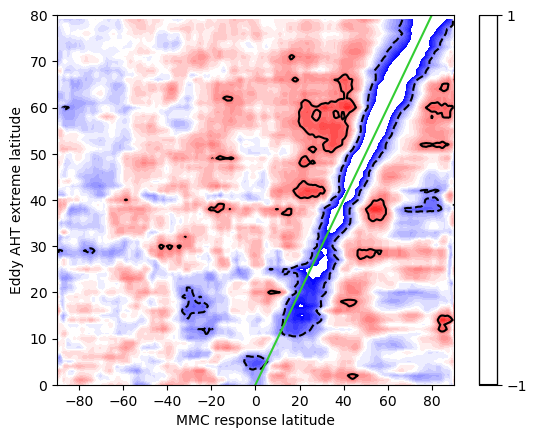

In [119]:
which_lat = 27

lat_idx = era_fncts.get_lat_idx(which_lat)

#To plot actual AHT differences
#plt.contourf(lats, test_lats, mmc_difs, levels=np.linspace(-4e15, 4e15, 30), cmap='bwr')

#To plot differences in std. devs.
plt.contourf(lats, test_lats, mmc_difs / mmc_std_ndjf.values[None, :], levels=np.linspace(-2, 2, 30), cmap='bwr')
plt.contour(lats, test_lats, mmc_difs / mmc_std_ndjf.values[None, :], levels=[-1, 1], colors='k')

plt.axline((0, 0), slope=1, color='limegreen')
#mmc_std = monthly_stds.mmc_aht_no_seasons[[0, 1, 10, 11],:].mean(['month']).sel(latitude=which_lat)
#plt.axhline(mmc_std, color='k')
plt.colorbar()

plt.ylim([0, 80])

plt.ylabel('Eddy AHT extreme latitude')
plt.xlabel('MMC response latitude')

plt.show()